In [16]:
import os
import numpy as np
import h5py
import json
import torch
#from scipy.misc import imread, imresize   #pip install scipy==1.1.0
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence


In [17]:
def save_checkpoint(epoch, encoder, decoder, decoder_optimizer):
    state = {'epoch': epoch,
             'encoder': encoder,
             'decoder': decoder,
             'decoder_optimizer': decoder_optimizer}
    file_name = 'checkpoint' + str(epoch) + '.pth'
    torch.save(state, file_name)


class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum =0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# out of the class
def adjust_learning_rate(optimizer, shrink_factor):
    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * shrink_factor  # this is how we can access the learning rate of the optimizer
    print("The new learning rate is : {:3f}".format(optimizer.param_groups[0]['lr']))

In [18]:
def accuracy(scores, targets, k):
    """
        scores: batch_size, max(decoding_length), vocal_size --> (sum(decoding_length), vocab_size)
        targets: batch_size, max(decoding_length),  --> sum(decoding_length)
    """
    batch_size = targets.size(0)
    _, indices = scores.topk(k,1)
    correct = indices.eq(targets.view(-1,1).expand_as(indices)) # make the same dimension of the tensor to be able to compare
    correct_total = correct.view(-1).float.sum()

    return correct_total * (100.0 / batch_size)


**DataSetClass**

In [19]:
class Flickr8kDataset(Dataset):

    def __init__(self, data_transforms):
        self.h = h5py.File('TRAIN_IMAGES.hdf5', 'r')   # this is the dataset format of the images, refer to the repo of reference of the data preparation https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning
        self.images = self.h['images']

        self.cpi = self.h.attrs['captions_pre_image']

        with open('TRAIN_CAPTIONS.json', 'r') as j:
            self.captions = json.load(j)
        
        with open('TRAIN_CAPLENS.json', 'r') as j:
            self.caplens = json.load(j)

        self.transform = data_transforms
        self.dataset_size = len(self.captions)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, i):
        images = torch.FloatTensor(self.images[i // self.cpi] // 255) ##captions per image

        if self.transform is not None:
            images = self.transform(images)
        
        caption = torch.LongTensor(self.captions[i])
        caplen = torch.LongTensor(self.caplens[i])

        return images, caption, caplen

In [20]:
train_loader = torch.utils.data.DataLoader(Flickr8kDataset(data_transforms=None), 
                                           batch_size=10,
                                           shuffle=True,
                                           pin_memory = True
                                           )

OSError: Unable to open file (unable to open file: name = 'TRAIN_IMAGES.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Model Class**

Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        resnet = torchvision.models.resnet101()
        all_modules = list(resnet.children())
        modules = all_modules[:, -2]
        self.resnet = nn.Sequential(*modules)

        self.avgpool = nn.AvgPool2d(8) # size of the feature map
        self.fine_tune()

    def fine_tune(self, fine_tune: bool):
        for p in self.resnet.parameters():
            p.requires_grad = fine_tune # if False, freezes the resnet Params, you wont train the net

    def forward(self, images):
        """
        images: (batch_size, 3, 254, 254)
        """
        batch_size = images.shape[0]
        encoded_image = self.resnet(images)
        global_features = self.avgpool(encoded_image).view(batch_size, -1)
        return global_features
    



**Model Class**

Decoder

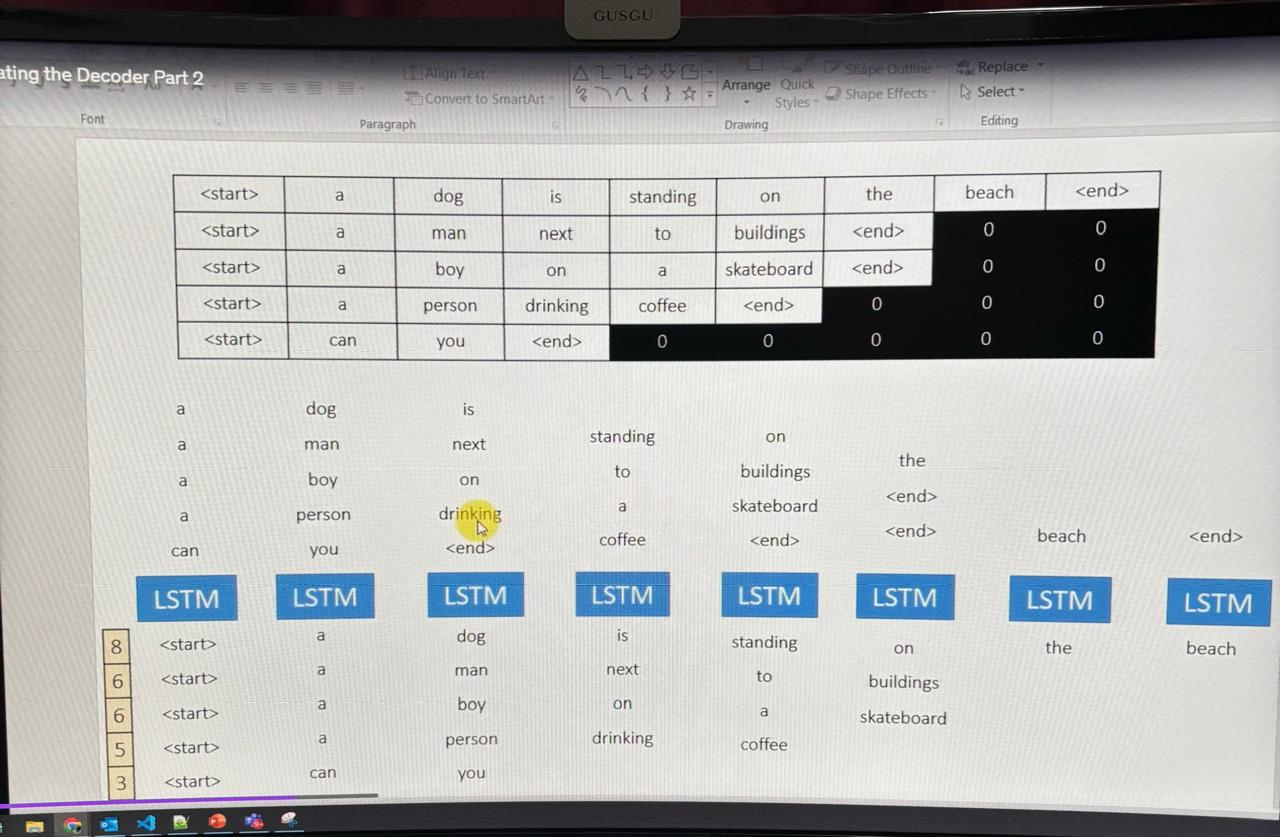

In [22]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim = 248):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size =vocab_size
        self.encoder_dim = encoder_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)  #uniform distribution
        self.fc.weight.data.uniform_(-0.1, 0.1)  # _ means inplace operation
        self.fc.bias.data.fill_(0)
    
    def init_hidden_states(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim).to(device)
        c = torch.zeros(batch_size, self.decoder_dim).to(device)
        return h, c

    def forward(self, global_image, encoded_captions, captions_lengths):
        batch_size = global_image.size(0)
        encoder_dimension = global_image.size(-1)
        captions_lengths, sort_ind = captions_lengths.squeeze(1).sort(dim =0, descending = True)
        global_image = global_image[sort_ind]
        encoded_captions = encoded_captions[sort_ind]   #(batch_size, max_length)
        embeddings = self.embedding(encoded_captions) #(batch_size, max_length, emb_dim)

        h, c = self.init_hidden_states(batch_size)
        decode_length = (captions_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_length), self.vocab_size)

        ##Loop over the LSTMCell
        for t in range(max(decode_length)):
            batch_size_t = sum([l >t for l in decode_length])
            lstm_input = torch.cat(embeddings[:batch_size_t, t, :], global_image[:batch_size_t], dim= -1)
            h, c = self.lstm(lstm_input, (h[: batch_size_t], c[: batch_size_t]))
            preds = self.fc(h)
            predictions[:batch_size_t, t, :] = preds
        
        return predictions, encoded_captions, decode_length, sort_ind


In [8]:
# this is an example on how to define the batch sizes
dec_lenghtss = [8,6,6,5,3]
for t in range(max(dec_lenghtss)):
    print(sum([l >t for l in dec_lenghtss]))

#The matrix it will produce, can be sum and produce the batch_sizes according to the LSTM
# [True, True, True, True, True]
# [True, True, True, True, True]
# [True, True, True, True, True]
# [True, True, True, True, False]
# [True, True, True, True, False]
# [True, True, True, False, False]
# [True, False, False, False, False]
# [True, False, False, False, False]

[True, True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, False]
[True, True, True, True, False]
[True, True, True, False, False]
[True, False, False, False, False]
[True, False, False, False, False]


In [25]:
def train(train_loader, encoder, decoder, criterion, decoder_optimizer, epoch):
    encoder.train()
    decoder.train()

    losses = AverageMeter()
    top3accuracies = AverageMeter()

    for i, (img, caption, caplen) in enumerate(train_loader):
        img = img.to(device)
        caption = caption.to(device)
        caplen = caplen.to(device)
        global_features = encoder(img)
        scores, caps_sorted, decode_lengths, sort_ind = decoder(global_features, caption, caplen)
        targets = caps_sorted[:,1:]
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
        loss = criterion(scores.data, targets.data)

        decoder_optimizer.zero_grad()
        loss.backward()
        decoder_optimizer.step()

        top3 = accuracy(scores=scores.data, targets=targets.data, k=3)
        losses.update(loss.item(), sum(decode_lengths))
        top3accuracies.update(top3, sum(decode_lengths))

        #print Logs

        if i% print_freq == 0:
            print('Epoch: [{0}][{1}]/{2}\t'
                  'Loss:{loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top3 Accurary {top3.val:.3f} ({top3.avg:3f})'.format(epoch, i, len(train_loader),
                                                                        loss=losses, top3=top3accuracies))


**Hyper Parameters**

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emb_dim = 512
decoder_dim = 512
decoder_lr = 5e-4
start_epoch = 0
epochs = 5
batch_size = 60
print_freq = 100
checkpoint = None

#Read word map

with open("WORDMAP_flickr8k.json", "r") as j:
    word_map = json.load(j)

rev_word_map = {v:k for k,v in word_map.items()}  #reverse dictionary#

if checkpoint is None:
    encoder = Encoder()
    decoder = Decoder(embed_dim=emb_dim, decoder_dim=decoder_dim, vocab_size=len(word_map))
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_lr)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1 
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']

encoder = encoder.to(device)
decoder = decoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])


train_loader = torch.utils.data.DataLoader(Flickr8kDataset(transform), 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory = True)

FileNotFoundError: [Errno 2] No such file or directory: 'WORDMAP_flickr8k.json'

**valuation function for image**

In [27]:
def greedy_decode(image):
    decoder.eval()
    encoder.eval()
    max_len = 20

    sampled=[]
    rev_word_map = {v:k for k,v in word_map.items()}
    img=imread(image)
    plt.imshow(image)
    #img = imresize(img, (256,256))  #(256,256,3)
    img = resize(img, (256,256))  #(256,256,3)
    img = img.transpose(2,0,1)      #(256,256,3)
    img = img/255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.squeeze(0)   #squeeze the image to have a shape of  (1,3,256,256)

    global_features = encoder(image)
    pred = torch.LongTensor([[word_map['<start>']]])   #(1,1)
    h,c = decoder.init_hidden_states(1)

    for timestep in range(max_len):
        embeddings = decoder.embedding(pred).squeeze(1)  #(1,1,512) ---> (1,512)
        lstm_input = torch.cat(embeddings, global_features, dim= -1)  #(1,512) cat (1,512) --> (1,1024)
        h, c = decoder.lstm(lstm_input, (h, c))
        preds = decoder.fc(h)   #(1, vocab_size)
        _, pred = preds.max(1)
        sampled.append(pred)
        
        if pred == word_map['<end>']:
            break

    generated_words = [rev_word_map[sampled[i]] for i in range(len(sampled))]
    filtered_words = " ".join([word for word in generated_words])
    print(filtered_words)



In [28]:
#Epochs

for epoch in range(start_epoch, epochs):
    #Decay the learning rate by 0.8 every 3 epochs

    if epoch % 3 == 0 and epoch != 0:
        adjust_learning_rate(decoder_optimizer, 0.8)

    #One epoch's  training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder = decoder,
          criterion=criterion,
          decoder_optimizer=decoder_optimizer,
          epoch = epoch
          )
    #Save checkpoint
    save_checkpoint(epoch, encoder, decoder, decoder_optimizer)

NameError: name 'train_loader' is not defined